In [13]:
import numpy as np
import seaborn as sns
import os, sys
from matplotlib import pyplot as plt
from sklearn import metrics

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

CURRENT_DIR = os.path.dirname(os.path.abspath("rare_pattern_detect"))
sys.path.append(os.path.dirname(CURRENT_DIR))

from rare_pattern_detect.patterns import PatternSpace, PatternSpaceType
from rare_pattern_detect.rare_pattern_detect import RarePatternDetect
from rare_pattern_detect.pattern_space_utils import draw_largest_bounding_area, draw2dpattern

# Evaluating 20 data points (10 anomalies and 10 normal points) using 200 training points

In [14]:
# # Loading the data
with np.load('../ADBench-main/datasets/Classical/33_skin.npz') as data:
    X = data['X']
    y = data['y']
    idx = np.random.permutation(len(X))
    X,y = X[idx], y[idx]

# TRAINING_LIMIT = 300 # 0
# FEATURES = 3
# X = X[:TRAINING_LIMIT,:FEATURES]
# y = y[:TRAINING_LIMIT]

In [15]:
anomalies_indices = [i for i, j in enumerate(y) if j == 1]

normal_indices = [i for i, j in enumerate(y) if j != 1]

print("anomalies_indices: ", len(anomalies_indices))

print("normal_indices: ", len(normal_indices))

testing_anomalies_indices = anomalies_indices[:10]

testing_normal_indices = normal_indices[-10:]

training_normal_indices = normal_indices[:200]

testing_indices = np.concatenate((testing_anomalies_indices, testing_normal_indices))

testing_labels = y[testing_indices]

y = testing_labels

anomalies_indices:  50859
normal_indices:  194198


In [18]:
training_set = np.array(X[training_normal_indices])

testing_set = np.array(np.concatenate((X[testing_anomalies_indices],X[testing_normal_indices])))

# 3D scatter plot

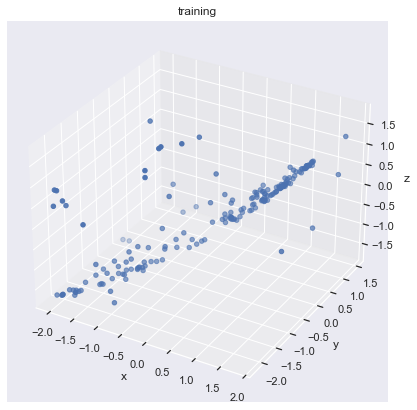

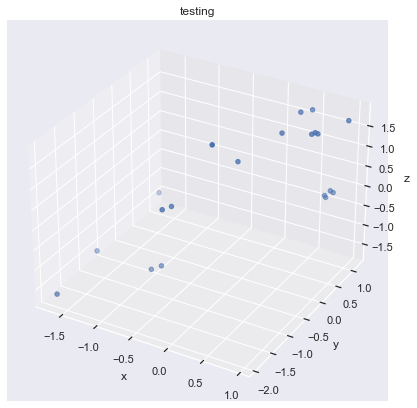

In [19]:
# training_set

from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")

def scatter_plot_3d(set, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    x = set[:,0]
    y = set[:,1]
    z = set[:,2]

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.scatter(x, y, z)
    ax.set_title(f"{title}")

    plt.show()

scatter_plot_3d(training_set, "training")
scatter_plot_3d(testing_set, "testing")

In [20]:
def calculate_f_hats(training_set, testing_set, y, min_area):
    initial_tau = 0.1
    epsilon = 0.1
    delta = 0.1

    print(f"num datapoints: {len(y)}")


    rpd = RarePatternDetect(
        delta=delta,
        tau=initial_tau,
        epsilon=epsilon,
        pattern_space = PatternSpace(
            type = PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
            cutoff = min_area
        )
    )

    rpd.fit(training_data=training_set, testing_data=testing_set)
    preds = []
    f_hats = []
    print("number of points to be classified: ", len(testing_set))
    for i, point_to_be_classified in enumerate(testing_set):
        # if i % 10 == 0: 
        print(f"----- {i} data points processed -----")
        model, prediction = rpd.predict_score(point_to_be_classified)
        preds.append(prediction)
        f_hats.append(model.minimized_f_hats) # [i])

    return f_hats

def evaluate_fhat_distribution(f_hats):
    ## Evaluating the f_hat distributions 
    indices = [i for i, j in enumerate(y) if j == 1]
    fhat_anomelies = [f_hats[i] for i, j in enumerate(indices)]
    fhat_normal = [j for i, j in enumerate(f_hats) if i not in indices]

    sns.histplot(fhat_normal, label=y, color="green")
    sns.histplot(fhat_anomelies, label=y, color="blue")
    plt.legend(labels=["normal","anormalies"])
    plt.title(f"f_hat distribution for min_area:{min_area}")
    plt.show()


In [21]:
# creating a range of taus
# taus = [0.00001, 0.0001, 0.001, 0.01 , 0.1, 0.2, 0.3, 0.5, 1.0] # np.linspace(start=0.1,stop=1.0,num=5)

taus = [0.1, 0.5, 1.0, 1.7, 1.8, 1.9]
min_areas = [36, 41, 48] # [4.6, 10, 20, 30, 46]
epsilon = 0.1

for i, min_area in enumerate(min_areas):
    print("iteration: ", i)

    f_hats = calculate_f_hats(training_set, testing_set, y, min_area)
    
    evaluate_fhat_distribution(f_hats)

    predictions_list = []

    for i, tau in enumerate(taus):
        print(f"––– ––– ––– new round: i={i}, mu :{(tau + (epsilon/2))}  ––– ––– –––")
        
        predictions = np.asarray(f_hats) < (tau + (epsilon/2))
        predictions_list.append([tau + (epsilon/2), min_area, predictions])

        preds = np.where(predictions==1, predictions, False).astype(bool)
        count_similar_predictions = np.count_nonzero(y == preds)
        per_similar_predictions = count_similar_predictions/len(y)
        print(f" correct results: {count_similar_predictions},  percentage: {per_similar_predictions}")


    for i, (tau,_,p) in enumerate(predictions_list):

        auc = metrics.roc_auc_score(y, p)

        # Recall that a model with an AUC score of 0.5 is no better than a model that performs random guessing.
        print("auroc: ",auc)

        fpr, tpr, _ = metrics.roc_curve(y, p)
        
        #create ROC curve
        plt.plot(fpr,tpr, label=f"mu: {np.round(tau+(epsilon/2), 3)}, auroc: {np.round(auc,3)}")
        plt.legend(loc="upper left")
        #print(fpr,tpr)

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

iteration:  0
num datapoints: 20
cutoff (patterns.py):  36
testing_data not empty
number of points to be classified:  20
----- 0 data points processed -----
